In [ ]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Define Poisson frequency distribution
lambda_ = 10  # Expected number of complaints
# _ underscore, since lambda is a Python keyword.

number_distribution = stats.poisson(mu=lambda_)

# Scipy doesn't have probability generating functions (PGF), so we need to implement it ourselves.

def number_pgf(z):
    return np.exp(-lambda_*(1-z)) # Poisson PGF

# Note: Use np.exp, not math.exp, to automatically work with Numpy arrays.

#    return (1-p+p*z)**n # Binomial PGF
#    return (p/(1-(1-p)*z))**r # Negative Binomial PGF

N_mean = number_distribution.mean()
N_var = number_distribution.var()

print(f"Probability of 1 or more claims: {1-number_distribution.pmf(0):.4f}")

Probability of 1 or more claims: 1.0000


In [ ]:
# Define Gamma severity distribution
alpha, theta = 2, 5  # Shape and rate (dispersion) parameters

severity_distribution = stats.gamma(a=alpha, scale=theta)

X_mean = severity_distribution.mean()
X_var = severity_distribution.var()

In [ ]:
# There are closed-form formulas for all moments of the compound distribution
# Although they become increasingly complicated.


S_mean = N_mean * X_mean
S_var = N_mean * X_var + N_var * X_mean**2

results = pd.DataFrame()
results["Exact Compound"] = {"Mean": S_mean, "Error %": 0, "Variance": S_var, "Var Error %": 0}
results.T

,Mean,Error %,Variance,Var Error %
Exact Compound,100.0,0.0,1500.0,0.0


# Discretization

Since we need to discretize for both **Panjer** and **FFT**, we will do it once and reuse it for both methods.

We will call **vectors** $f$ and $g$ the discretized versions of $F(x)$ and $G(x)$, which represent respectively the **composite distribution** and the **severity distribution**.

> **Note:** This is not an ideal way to discretize a probability distribution. It generally **does not preserve moments**. For a better approximation, **a moment-preserving discretization could be considered**.

For the **FFT to work correctly**, both $f$ and $g$ must have the **same length**. Furthermore, the FFT algorithm is designed to work with vectors whose length is a **power of 2**, that is, we want $k+1$ to be a power of 2.

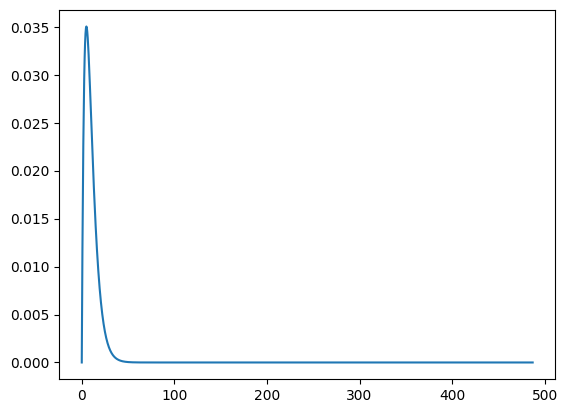

,Mean,Error %,Variance,Var Error %
Exact G,10.000000,0.000000,50.000000,0.000000
Regular grid discretization of G,10.007562,0.075623,49.962200,-0.075600
G bin center,10.000001,0.000011,50.018868,0.037737
Zero as special,10.000001,0.000011,50.018868,0.037737


In [ ]:
# Both Panjer and FFT require discretization.

g_versions = pd.DataFrame()
g_versions["Exact G"] = {
    "Mean": severity_distribution.mean(), "Error %": 0,
    "Variance": severity_distribution.var(), "Var Error %": 0}

vector_len = 1024

# To determine how far to discretize, we take a quantile:
G_max = severity_distribution.ppf(0.99999)

# Since for F, we do not know the quantile, we take the mean plus 10 times the standard deviation:
F_max = S_mean + 10 * math.sqrt(S_var)

# We order the values
x_max = max(G_max, F_max)

h = x_max / (vector_len - 1)

# Regular grid discretization
x_vals = np.linspace(0, x_max, vector_len)  # X-axis range
g = severity_distribution.pdf(x_vals)
g /= g.sum()

g_mean = np.sum(x_vals * g)
g_var = np.sum(x_vals**2 * g) - g_mean**2

g_versions["Regular grid discretization of G"] = {
    "Mean": g_mean,
    "Error %": (g_mean-severity_distribution.mean())*100/severity_distribution.mean(),
    "Variance": g_var,
    "Var Error %": (g_var-severity_distribution.var())*100/severity_distribution.var()
    }

# To be more precise, let x be the center of the bins and use the difference of the CDF.
x_vals = np.linspace(h/2, x_max+h/2, vector_len)  # X-axis range
g = severity_distribution.cdf(x_vals+h/2) - severity_distribution.cdf(x_vals-h/2)
g[0] = severity_distribution.cdf(h) # just in case there is mass at negative points

g /= g.sum()

g_mean = np.sum(x_vals * g)
g_var = np.sum(x_vals**2 * g) - g_mean**2

g_versions["G bin center"] = {
    "Mean": g_mean,
    "Error %": (g_mean-severity_distribution.mean())*100/severity_distribution.mean(),
    "Variance": g_var,
    "Var Error %": (g_var-severity_distribution.var())*100/severity_distribution.var()
    }


# Treat zero as special. g[0] = G(0). g[k] = mass of G at x ( h (k - 1), h k]
x_vals = np.linspace(-h/2, x_max-h/2, vector_len)  # X-axis range
x_vals[0] = 0

g[0] = severity_distribution.cdf(h*1e-10)  # handles the true point mass if present
g[2:] = severity_distribution.cdf(x_vals[2:]+h/2) - severity_distribution.cdf(x_vals[2:]-h/2)
g[1] = 1 - g[0] - g[2:].sum()

g_mean = np.sum(x_vals * g)
g_var = np.sum(x_vals**2 * g) - g_mean**2

g_versions["Zero as special"] = {
    "Mean": g_mean,
    "Error %": (g_mean-severity_distribution.mean())*100/severity_distribution.mean(),
    "Variance": g_var,
    "Var Error %": (g_var-severity_distribution.var())*100/severity_distribution.var()
    }

plt.plot(x_vals, g)
plt.show()

g_versions.T

#Panjer Recursion

Total mass of f, before normalizing: 0.9999999999555529


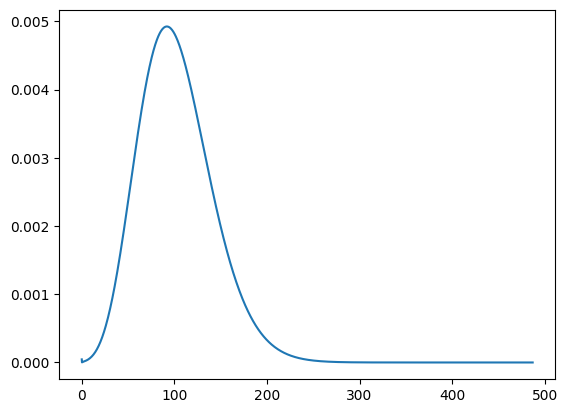

In [ ]:

# initialize f
f = np.zeros(vector_len)

f[0] = number_pgf(g[0])

# (a,b,0), assuming Poisson
a = 0
b = lambda_

# note: ranges in Python _exclude_ the upper index!
for k in range(1, vector_len):
  for i in range(1, k+1):
    f[k] += (a + (b * i)/k) * g[i] * f[k-i]


f /= (1 - a * g[0])

print(f"Total mass of f, before normalizing: {f.sum()}")

f /= f.sum()

plt.plot(x_vals, f)
plt.show()

In [ ]:
S_panjer_mean = np.sum(x_vals * f)
S_panjer_var = np.sum(x_vals**2 * f) - S_panjer_mean**2

results["Panjer Compound"] = {
    "Mean": S_panjer_mean,
    "Error %": (S_panjer_mean-S_mean)*100/S_mean,
    "Variance": S_panjer_var,
    "Var Error %": (S_panjer_var-S_var)*100/S_var}

results.T

,Mean,Error %,Variance,Var Error %
Exact Compound,100.000000,0.000000,1500.000000,0.00000
Panjer Compound,102.143563,2.143563,1548.388202,3.22588


# Fast Fourier Transforms

Total mass of f, before normalizing: 1.0


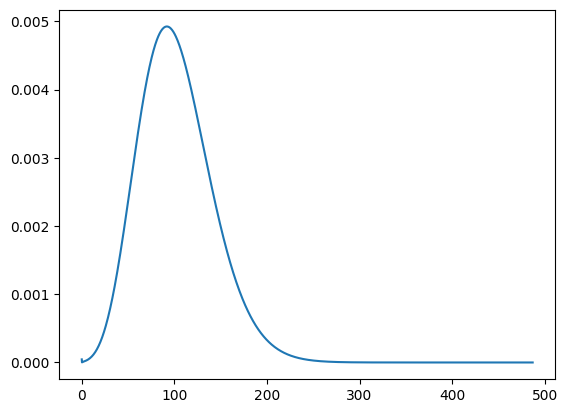

In [ ]:
g_tilde = np.fft.fft(g)

f_tilde = number_pgf(g_tilde)

f = np.fft.ifft(f_tilde)

f = np.real(f)

f[f < 0] = 0 # as a precaution.

print(f"Total mass of f, before normalizing: {f.sum()}")

f /= f.sum()

plt.plot(x_vals, f)
plt.show()

In [ ]:
S_fft_mean = np.sum(x_vals * f)
S_fft_var = np.sum(x_vals**2 * f) - S_fft_mean**2

results["FFT Compound"] = {
    "Mean": S_fft_mean,
    "Error %": (S_fft_mean-S_mean)*100/S_mean,
    "Variance": S_fft_var,
    "Var Error %": (S_fft_var-S_var)*100/S_var}

results.T

,Mean,Error %,Variance,Var Error %
Exact Compound,0.100000,0.000000,1.500000,0.000000
Panjer Compound,0.099993,-0.007397,1.499371,-0.041953
FFT Compound,0.099993,-0.007291,1.499372,-0.041877


# Monte Carlo

In [ ]:
Nr_of_simulations = 10000

print(f"Error order: {100/math.sqrt(Nr_of_simulations):.1f}%\n")

N = number_distribution.rvs(size=Nr_of_simulations)  # Simulate claim counts
X = severity_distribution.rvs(size=Nr_of_simulations)  # Simulate claim amounts

Error order: 1.0%



In [ ]:
# Calculate the composite distribution (total losses per policy)
S = np.array([sum(severity_distribution.rvs(size=n)) for n in N])

results["Monte Carlo Compound"] = {
    "Mean": S.mean(),
    "Error %": (S.mean()-S_mean)*100/S_mean,
    "Variance": S.var(),
    "Var Error %": (S.var()-S_var)*100/S_var}

results.T

,Mean,Error %,Variance,Var Error %
Exact Compound,100.000000,0.000000,1500.000000,0.000000
Panjer Compound,102.143563,2.143563,1548.388202,3.225880
Monte Carlo Compound,100.281214,0.281214,1497.791349,-0.147243


#Tweedie

In [ ]:
# To compare with Tweedie, use a library that is at version 0.09. Just for reference.

!pip install tweedie

import tweedie

In [ ]:
# 🔹 Compute "exact Tweedie" density 🔹
# Estimate Tweedie parameters based on compound Poisson-Gamma
mu_tweedie = lambda_ * alpha * theta  # Mean
p_tweedie = (alpha + 2) / (alpha + 1)  # Power parameter
phi_tweedie = lambda_**(1-p_tweedie)*((alpha*theta)**(2-p_tweedie))/(2-p_tweedie)  # Dispersion parameter

# Generate values for plotting Tweedie density
x_vals = np.linspace(0, np.max(S), 1000)  # X-axis range

# Compute Tweedie PDF (density function)

twd = tweedie.tweedie(mu=mu_tweedie, p=p_tweedie, phi=phi_tweedie)
tweedie_pdf = twd.pdf(x_vals)

print(f" mu_tweedie: {mu_tweedie:.2f}")
print(f"  p_tweedie: {p_tweedie:.2f}")
print(f"phi_tweedie: {phi_tweedie:.2f}")

 mu_tweedie: 1.00
  p_tweedie: 1.33
phi_tweedie: 15.00


In [ ]:
results["Tweedie Compound"] = {
    "Mean": twd.mean(),
    "Error %": (twd.mean()-S_mean)*100/S_mean,
    "Variance": twd.var(),
    "Var Error %": (twd.var()-S_var)*100/S_var}

results.T

,Mean,Error %,Variance,Var Error %
Exact Compound,1.000000,0.000000e+00,15.000000,0.000000e+00
Panjer Compound,1.005295,5.295453e-01,15.243675,1.624501e+00
FFT Compound,1.005306,5.306242e-01,15.243771,1.625141e+00
Monte Carlo Compound,0.997018,-2.982115e-01,14.897708,-6.819489e-01
Tweedie Compound,1.000000,-1.476780e-08,15.000000,4.213601e-09


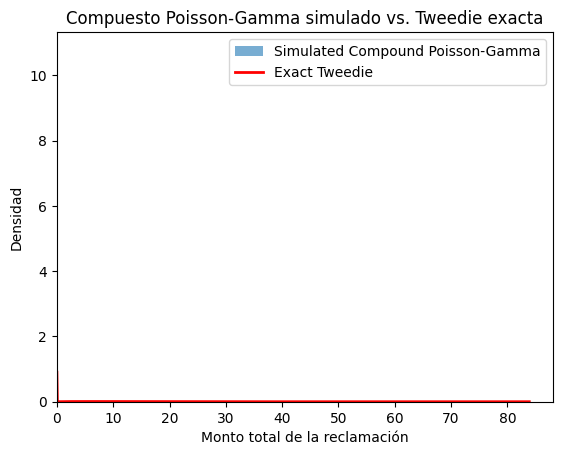

In [ ]:
# Plot the histogram of the simulated losses of the Poisson-Gamma compound
plt.hist(S, bins=1000, density=True, alpha=0.6, label="Simulated Compound Poisson-Gamma")

# Plot the theoretical Tweedie distribution as a smooth line
plt.plot(x_vals, tweedie_pdf, 'r-', lw=2, label="Exact Tweedie")

# End the plot
plt.xlabel("Total amount of the claim")
plt.ylabel("Density")
plt.legend()
plt.title("Simulated Poisson-Gamma Compound vs. Exact Tweedie")

plt.xlim(left=0.0)

plt.show()